# Notebook 3: Operational Economics (The Cash Inflow)

Block 1: Setup & Assumptions

We define the operating parameters of our "Model Plant" (1100 MW) and the market conditions it will face.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
sns.set_theme(style="whitegrid")

print("--- Notebook 3: Operational Economics (The Cash Inflow) ---")

# 1. Define Operational Assumptions
# These are standard industry assumptions for a modern Gen III+ reactor
OPERATIONAL_LIFE_YEARS = 60
CAPACITY_FACTOR = 0.92 # Modern plants aim for >90%
NAMEPLATE_CAPACITY_MW = 1100 # From Notebook 2

# Electricity Price Scenarios ($/MWh)
# This is the biggest driver of revenue
POWER_PRICES = {
    'Bear_Power': 50,   # Cheap gas competition
    'Base_Power': 75,   # Reasonable long-term average
    'Bull_Power': 100   # Carbon pricing / High demand
}

# Cost Assumptions (2025 Dollars)
# Fixed O&M: Staffing, insurance, regulatory fees ($/kW-year)
FIXED_OM_COST_KW_YR = 100
# Variable O&M: Consumables, waste, water ($/MWh)
VARIABLE_OM_COST_MWH = 2.0
# Fuel Cost: Uranium + Enrichment + Fab ($/MWh) - simplified
FUEL_COST_MWH = 7.0

print(f"Operational Life: {OPERATIONAL_LIFE_YEARS} years")
print(f"Capacity Factor: {CAPACITY_FACTOR:.0%}")
print(f"Power Price Scenarios: {POWER_PRICES}")
print(f"Fixed O&M: ${FIXED_OM_COST_KW_YR}/kW-yr")
print(f"Variable Costs (Fuel+Var O&M): ${VARIABLE_OM_COST_MWH + FUEL_COST_MWH}/MWh")

--- Notebook 3: Operational Economics (The Cash Inflow) ---
Operational Life: 60 years
Capacity Factor: 92%
Power Price Scenarios: {'Bear_Power': 50, 'Base_Power': 75, 'Bull_Power': 100}
Fixed O&M: $100/kW-yr
Variable Costs (Fuel+Var O&M): $9.0/MWh


Block 2: Generating the Cash Flow Schedule

We calculate the annual revenue, operating expenses (OPEX), and resulting Operating Cash Flow (EBITDA proxy) for each year of the plant's life.

In [11]:
print("Calculating Annual Operating Cash Flows...")

# 1. Create Operational Timeline
years = np.arange(1, OPERATIONAL_LIFE_YEARS + 1)
df_ops = pd.DataFrame({'Oper_Year': years})

# 2. Calculate Physical Generation
# MWh = MW * 8760 hrs * Capacity Factor
annual_generation_mwh = NAMEPLATE_CAPACITY_MW * 8760 * CAPACITY_FACTOR
df_ops['Annual_Generation_MWh'] = annual_generation_mwh

# 3. Calculate Operating Costs (Outflows)
# These are generally consistent regardless of power price
# Fixed O&M
annual_fixed_om = NAMEPLATE_CAPACITY_MW * 1000 * FIXED_OM_COST_KW_YR / 1e6 # Convert to $Millions
# Variable O&M
annual_var_om = annual_generation_mwh * VARIABLE_OM_COST_MWH / 1e6 # Convert to $Millions
# Fuel Cost
annual_fuel = annual_generation_mwh * FUEL_COST_MWH / 1e6 # Convert to $Millions

total_opex_millions = annual_fixed_om + annual_var_om + annual_fuel
df_ops['Annual_OPEX_M'] = total_opex_millions

# 4. Calculate Revenue & Cash Flow for Each Scenario (Inflows)
for scenario, price in POWER_PRICES.items():
    # Revenue = Generation * Price
    rev_col = f'Revenue_M_{scenario}'
    df_ops[rev_col] = (annual_generation_mwh * price) / 1e6

    # Operating Cash Flow (EBITDA proxy) = Revenue - OPEX
    cf_col = f'Op_CashFlow_M_{scenario}'
    df_ops[cf_col] = df_ops[rev_col] - df_ops['Annual_OPEX_M']

print(f"Calculated operational economics for {OPERATIONAL_LIFE_YEARS} years.")
print(f"Annual Generation: {annual_generation_mwh:,.0f} MWh")
print(f"Annual OPEX: ${total_opex_millions:.1f} Million")
print("-" * 30)
print(df_ops[['Oper_Year', 'Revenue_M_Base_Power', 'Op_CashFlow_M_Base_Power']].head())

Calculating Annual Operating Cash Flows...
Calculated operational economics for 60 years.
Annual Generation: 8,865,120 MWh
Annual OPEX: $189.8 Million
------------------------------
   Oper_Year  Revenue_M_Base_Power  Op_CashFlow_M_Base_Power
0          1               664.884                 475.09792
1          2               664.884                 475.09792
2          3               664.884                 475.09792
3          4               664.884                 475.09792
4          5               664.884                 475.09792


Block 3: Visualization & Export

We plot the cumulative cash generation to visualize the massive long-term value of the asset.

Visualizing Cumulative Cash Generation...


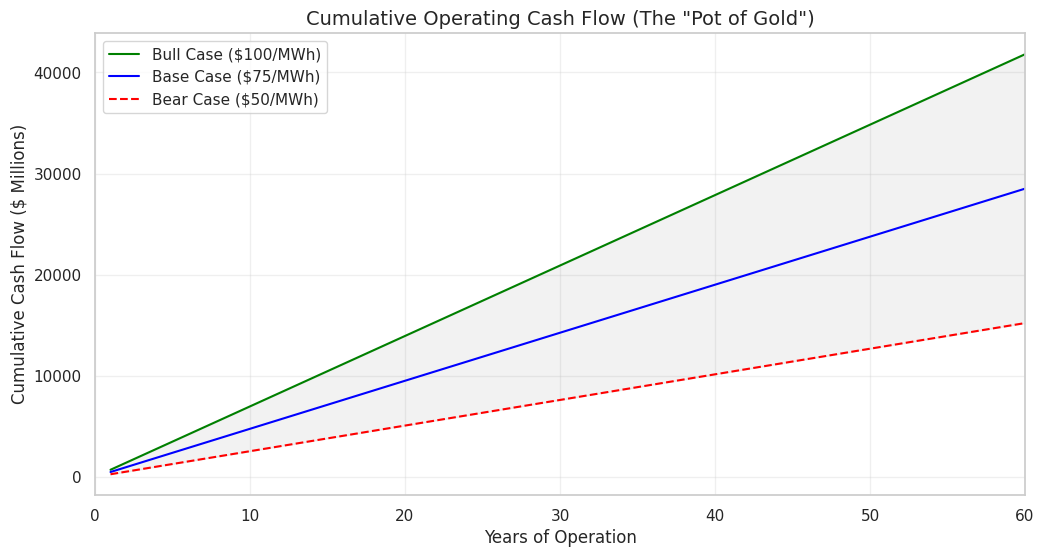

Operational Economics saved to 'operational_economics.csv'. Ready for Notebook 4.


In [12]:
print("Visualizing Cumulative Cash Generation...")

# 1. Calculate Cumulative Cash Flow for Visualization
df_viz = df_ops.copy()
for scenario in POWER_PRICES.keys():
    df_viz[f'Cum_CF_{scenario}'] = df_viz[f'Op_CashFlow_M_{scenario}'].cumsum()

# 2. Plot
plt.figure(figsize=(12, 6))

plt.plot(df_viz['Oper_Year'], df_viz['Cum_CF_Bull_Power'], color='green', label='Bull Case ($100/MWh)')
plt.plot(df_viz['Oper_Year'], df_viz['Cum_CF_Base_Power'], color='blue', label='Base Case ($75/MWh)')
plt.plot(df_viz['Oper_Year'], df_viz['Cum_CF_Bear_Power'], color='red', linestyle='--', label='Bear Case ($50/MWh)')

plt.fill_between(df_viz['Oper_Year'], df_viz['Cum_CF_Bear_Power'], df_viz['Cum_CF_Bull_Power'], color='gray', alpha=0.1)

plt.title('Cumulative Operating Cash Flow (The "Pot of Gold")', fontsize=14)
plt.xlabel('Years of Operation')
plt.ylabel('Cumulative Cash Flow ($ Millions)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 60)
plt.show()

# 3. Export
df_ops.to_csv('operational_economics.csv', index=False)
print("Operational Economics saved to 'operational_economics.csv'. Ready for Notebook 4.")

Block 4: Visualization & Export

We visualize the "S-Curve" and the annual cash burden.

Visualizing CAPEX Cash Flows...


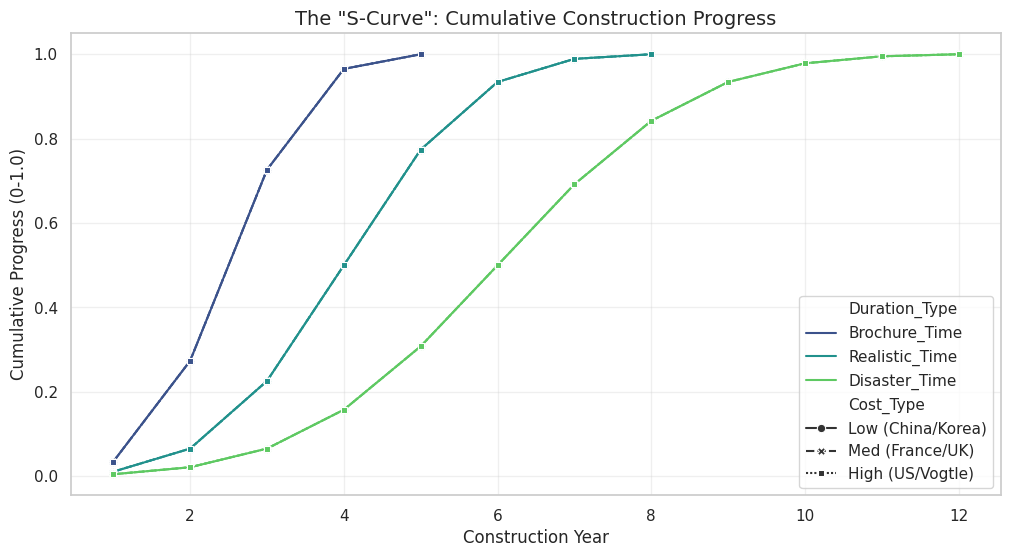

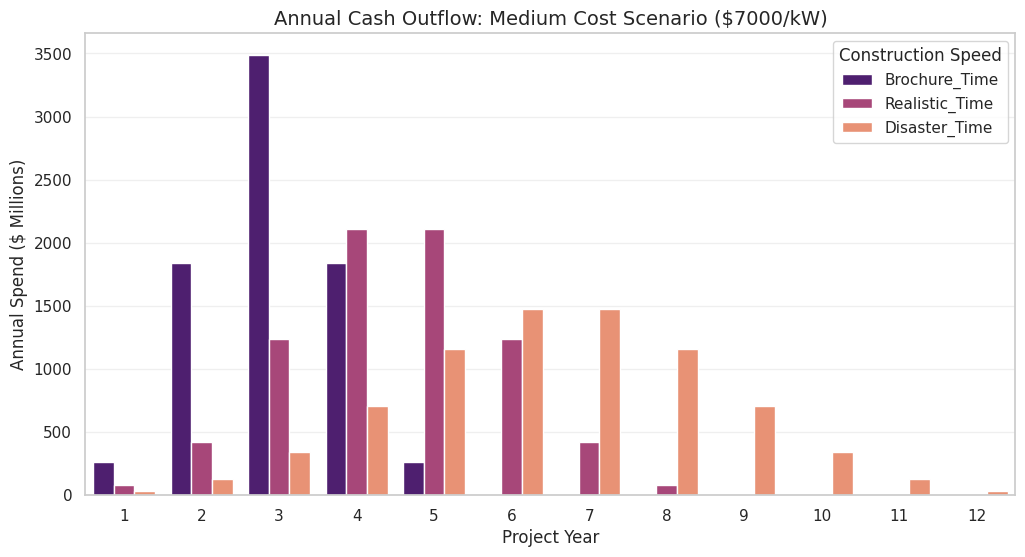

CAPEX Schedule saved to 'capex_schedule.csv'. Ready for Notebook 3.


In [13]:
print("Visualizing CAPEX Cash Flows...")

# 1. Plot Cumulative Spending (S-Curve)
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_capex,
    x='Year_Index',
    y='Cumulative_Progress_%',
    hue='Duration_Type',
    style='Cost_Type',
    markers=True,
    palette='viridis'
)
plt.title('The "S-Curve": Cumulative Construction Progress', fontsize=14)
plt.ylabel('Cumulative Progress (0-1.0)')
plt.xlabel('Construction Year')
plt.grid(True, alpha=0.3)
plt.show()

# 2. Plot Annual Cash Outflow (The Burden)
# Filter for just one Cost Scenario (e.g., Med) to see Duration impact clearly
df_plot_med = df_capex[df_capex['Cost_Type'] == 'Med (France/UK)']

plt.figure(figsize=(12, 6))
sns.barplot(
    data=df_plot_med,
    x='Year_Index',
    y='Annual_Spend_M',
    hue='Duration_Type',
    palette='magma'
)
plt.title('Annual Cash Outflow: Medium Cost Scenario ($7000/kW)', fontsize=14)
plt.ylabel('Annual Spend ($ Millions)')
plt.xlabel('Project Year')
plt.legend(title='Construction Speed')
plt.grid(axis='y', alpha=0.3)
plt.show()

# 3. Export
df_capex.to_csv('capex_schedule.csv', index=False)
print("CAPEX Schedule saved to 'capex_schedule.csv'. Ready for Notebook 3.")